# Part 1 - Baseline Solution


## Naïve Bayes approach

$$\hat{c} = argmax_{c∈\{0, 1\}}\biggl[\sum \limits_{i=1}^{k}log(\theta_{c, w_{i}})\biggr]$$where $\theta_{c, w_{i}}=\frac{n_{c,w}+\alpha}{n_{c}+k\alpha}$.

Class likelihoods have been omitted due to the structure of the dataset (50/50 split between negative and positive sentiments).

## Code

In [1]:
import re
import time
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

In [2]:
class SentimentClassifier:
    def __init__(self, saved_weights=False):
        try:
            nltk.data.find('tokenizers/punkt')
            nltk.data.find('corpora/stopwords')
        except LookupError:
            nltk.download('punkt')
            nltk.download('stopwords')

        if saved_weights:
            """Loading saved weights for predictions"""
            npz_files = np.load(saved_weights, allow_pickle=True)
            self._vocabulary = npz_files['vocab'].tolist()
            self._class_conditional_likelihoods = npz_files['weights']
        else:
            self._vocabulary = None
            self._class_conditional_likelihoods = None

        self._training_data = None
        self._training_labels = None
        self._bag_of_words = None

    @staticmethod
    def preProcessing(parsedData):
        """
        Given a dataset containing labels followed by the review comment,
        process the data into the right format - label turns into a boolean variable
        and a comment is being filtered out of the stop words,
        stemmed and parsed into a list of strings.

        :param parsedData: a two-dimensional array of input data
        :return: labels and processed data
        """
        stopWords = set(stopwords.words('english'))

        def filterStopWords(toFilter): return [word.lower() for word in toFilter if not word.lower() in stopWords]

        stemmer = SnowballStemmer(language='english')
        car_reviews = np.array(parsedData)

        for row in car_reviews:
            row[0] = 1 if row[0] == 'Pos' else 0
            row[1] = ' '.join([stemmer.stem(word) for word in filterStopWords(word_tokenize(row[1]))])

        return car_reviews[:, 0], car_reviews[:, 1]

    def __vectorize(self, data):
        """
        Vectorizing the text samples, saving the vocabulary and sorting it.

        :return bag_of_words: fully-processed text data
        """

        def preprocess(text):
            """Filtering out all the numbers and leftover dots"""
            return re.sub(r'\d+|[.]', '', text)

        vectorizer = CountVectorizer(binary=True, max_features=750, vocabulary=self._vocabulary,
                                     preprocessor=preprocess)
        bag_of_words = vectorizer.fit_transform(data).toarray()
        if self._vocabulary is None:
            self._vocabulary = dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1]))

        return bag_of_words

    def __naiveBayes(self):
        """
        Given a dataset with binary features (words), calculate the empirical
        class-conditional likelihoods, that is, (P(w_i | c))
        for all features w_i and both classes (c in {0, 1}).
        Assume a multinomial feature distribution and use Laplace smoothing.
        """
        # ALPHA parameter chosen via trial and error
        ALPHA = 0.175
        features = self._bag_of_words
        labels = self._training_labels
        feature_size = features.shape[1]
        theta = np.empty((2, feature_size))

        pos_features = []
        neg_features = []
        for i, row in enumerate(features):
            pos_features.append(row) if labels[i] == 1 else neg_features.append(row)
        pos_features = np.array(pos_features)
        neg_features = np.array(neg_features)

        for i, feature in enumerate(np.transpose(pos_features)):
            theta[0][i] = (sum(feature) + ALPHA) / (feature_size * ALPHA + len(feature))

        for i, feature in enumerate(np.transpose(neg_features)):
            theta[1][i] = (sum(feature) + ALPHA) / (feature_size * ALPHA + len(feature))

        self._class_conditional_likelihoods = theta

    def __evaluate(self, data):
        """
        Given a dataset with binary features, predict the corresponding
        response for each instance (row) of the data set.

        :param data: a two-dimensional numpy-array with shape = [n_test_samples, n_features].
            theta[j, i] corresponds to the probability of feature i appearing in a sample belonging to class j.
        :return class_predictions: a numpy array containing the class predictions for each row of data.
        """
        class_predictions = np.empty(data.shape[0], dtype=np.int8)

        for i, sample in enumerate(data):
            p_feature_given_neg = np.empty(sample.shape)
            p_feature_given_pos = np.empty(sample.shape)

            for j, feature in enumerate(sample):
                if feature == 0:
                    p_feature_given_neg[j] = np.log2(1 - self._class_conditional_likelihoods[1][j])
                    p_feature_given_pos[j] = np.log2(1 - self._class_conditional_likelihoods[0][j])
                elif feature == 1:
                    p_feature_given_neg[j] = np.log2(self._class_conditional_likelihoods[1][j])
                    p_feature_given_pos[j] = np.log2(self._class_conditional_likelihoods[0][j])

            neg_log_product = np.sum(p_feature_given_neg)
            pos_log_product = np.sum(p_feature_given_pos)

            class_predictions[i] = 1 if pos_log_product > neg_log_product else 0

        return class_predictions

    def train(self, data, save_weights=False):
        """
        Training manager function - Data wrangling and training.

        :param data: a two-dimensional array of input data
        :param save_weights: flag indicator to save the current weights and vocabulary for future predictions
        """
        self._training_labels, self._training_data = self.preProcessing(data)
        self._bag_of_words = self.__vectorize(self._training_data)
        self.__naiveBayes()
        if save_weights:
            np.savez_compressed('resources/weights_and_vocab.npz', weights=self._class_conditional_likelihoods, vocab=self._vocabulary)

    def predict(self, data):
        """
        Prediction manager function - Data wrangling and evaluating based on saved weights.

        :param data: a two-dimensional array of input data
        :return predictions: a vector of binary predictions
        """
        labels, processed_data = self.preProcessing(data)
        features = self.__vectorize(processed_data)
        predictions = self.__evaluate(features)
        conf_matrix = confusion_matrix(labels.astype(int), predictions)
        training_set_accuracy = np.mean(np.equal(predictions, labels)) * 100

        return conf_matrix, training_set_accuracy

## Code Flow Explained:

In [3]:
# 1. parsing the CSV file
parsedData = pd.read_csv('resources/car-reviews.csv')

# 2. Test/Train split
train_data, test_data = train_test_split(parsedData, test_size=0.2, random_state=42)

In [4]:
# 3. Creating the classifier object
classifier = SentimentClassifier()

# 4. Calling a train function (timing the operation)
train_start_time = time.process_time()
classifier.train(train_data, save_weights=True)
train_end_time = time.process_time()

<pre><code><em><span style="color:darkcyan"># 5. Input data goes into preprocessing</span></em>
self._training_labels, self._training_data = 
    self.preProcessing(data)

<em><span style="color:darkcyan"># 5.1 Actual sentiments are written to a binary variable</span></em>
<em><span style="color:darkcyan"># 5.2 Reviews are being stemmed and filter out of stop words</span></em>
for row in car_reviews:
    row[0] = 1 if row[0] == 'Pos' else 0
    row[1] = ' '.join([stemmer.stem(word)
        for word in filterStopWords(word_tokenize(row[1]))])</code></pre>

<pre><code><em><span style="color:darkcyan"># 6. Input data gets vectorized</span></em>
self._bag_of_words = self.__vectorize(self._training_data)

<em><span style="color:darkcyan"># 6.1 Fitting and transforming the reviews</span></em>
bag_of_words = vectorizer.fit_transform(data).toarray()

<em><span style="color:darkcyan"># 6.2 Sorting the vocabulary (if not loaded from a file)</span></em>
self._vocabulary = dict(sorted(vectorizer.vocabulary_.items(),
    key=lambda item: item[1]))</code></pre>

<pre><code><em><span style="color:darkcyan"># 7. Initiating the Naive Bayes algorithm</span></em>
self.__naiveBayes()

<em><span style="color:darkcyan"># 7.1 Splitting the sentiment features</span></em>
for i, row in enumerate(features):
    pos_features.append(row) if labels[i] is 1 
        else neg_features.append(row)

<em><span style="color:darkcyan"># 7.2 Calculating theta of each feature for each sentiment - 
Using Laplace Smoothing technique in case of words that appear only in one class</span></em>
for i, feature in enumerate(np.transpose(pos_features)):
    theta[0][i] = (sum(feature) + ALPHA) / 
        (feature_size * ALPHA + len(feature))

for i, feature in enumerate(np.transpose(neg_features)):
    theta[1][i] = (sum(feature) + ALPHA) / 
        (feature_size * ALPHA + len(feature))</code></pre>

<pre><code><em><span style="color:darkcyan"># 8. Saving the thetas and vocabulary to an .npz file - 
Vocabulary dictionary helps to deal with the new words that would appear in the test data. This way we stick to the single collection of words from the training process and use them to calculate the final prediction.</span></em>
np.savez_compressed('resources/weights_and_vocab.npz', 
    weights=self._class_conditional_likelihoods, 
    vocab=self._vocabulary)</code></pre>

In [5]:
# 9. Testing the algorithm using the testing data (timing the operation)
test_start_time = time.process_time()
conf_matrix, accuracy = classifier.predict(test_data)
test_end_time = time.process_time()

<pre><code><em><span style="color:darkcyan"># 10. Input data goes into preprocessing (see step 5 for details)</span></em>
labels, processed_data = self.preProcessing(data)</code></pre>

<pre><code><em><span style="color:darkcyan"># 11. Input data gets vectorized (see step 6 for details)</span></em>
features = self.__vectorize(processed_data)</code></pre>

<pre><code><em><span style="color:darkcyan"># 12. Calling the evaluate function</span></em>
predictions = self.__evaluate(features)

<em><span style="color:darkcyan"># 12.1 Calculating the sum of all logs of theta for each sample based on the vectorized input</span></em>
for j, feature in enumerate(sample):
    if feature == 0:
        p_feature_given_neg[j] = 
            np.log2(1 - self._class_conditional_likelihoods[1][j])
        p_feature_given_pos[j] = 
            np.log2(1 - self._class_conditional_likelihoods[0][j])
    elif feature == 1:
        p_feature_given_neg[j] = 
            np.log2(self._class_conditional_likelihoods[1][j])
        p_feature_given_pos[j] = 
            np.log2(self._class_conditional_likelihoods[0][j])
neg_log_product = np.sum(p_feature_given_neg)
pos_log_product = np.sum(p_feature_given_pos)

<em><span style="color:darkcyan"># 12.2 Evaluating which class is more likely given the log products</span></em>
class_predictions[i] = 
    1 if pos_log_product > neg_log_product else 0
</code></pre>

<pre><code><em><span style="color:darkcyan"># 13. Generating the confusion matrix and the accuracy, and returning the results</span></em>
conf_matrix = confusion_matrix(labels.astype(int), predictions)
training_set_accuracy = np.mean(np.equal(predictions, labels)) * 100
</code></pre>

## Final Score

Accuracy: 81.5884%
Training time: 3.7188s
Testing time: 1.4062s


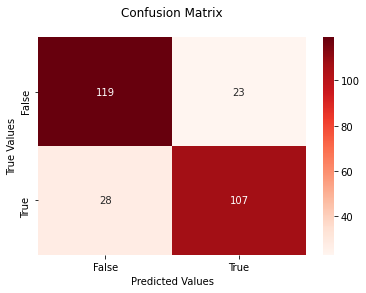

In [6]:
print(f"Accuracy: {accuracy:.4f}%\n"
      f"Training time: {train_end_time - train_start_time:.4f}s\n"
      f"Testing time: {test_end_time - test_start_time:.4f}s")
ax = sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

## Demonstrations

In this part, I will be pasting in the code snippets and executing them using makeshift examples to demonstrate that the assessment criteria are met.

#### Criteria 1, 2 and 3: Excluding the stop words and punctuation; Handling words  in case-insensitive way; Recognising words with the same stem

In [7]:
example_string = """
123, Knight, knightly, knights, CONSIGN, consigned, consigning,
kNiTtInG, KNit, knits, knitted, 6412. - ? ! """

In [8]:
stopWords = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')

def filterStopWords(toFilter): 
    return [word.lower() for word in toFilter if not word.lower() in stopWords]
def preprocess(text): 
    return re.sub(r'\d+|[.,-?!]', '', text)

filtering_stop_words = filterStopWords(word_tokenize(example_string))
stemming = ' '.join([stemmer.stem(word) for word in filtering_stop_words])
preprocess(stemming)
# NOTE: Excess whitespace is being dealt with automatically inside the vectorizer

'  knight  knight  knight  consign  consign  consign  knit  knit  knit  knit      '

#### Criterion 4: Producing a vector of each review containing a set of binary values indicating the presence of the word/stem in that review

In [9]:
demo_reviews = pd.read_csv('resources/car-reviews-demo.csv')
demo_classifier = SentimentClassifier()
demo_classifier.train(demo_reviews)

In [10]:
print(f"Vocab size: {len(demo_classifier._vocabulary)}\n"
      f"Bag of words shape: {demo_classifier._bag_of_words.shape}")

Vocab size: 750
Bag of words shape: (10, 750)


In [11]:
demo_classifier._bag_of_words

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [12]:
demo_classifier._vocabulary

{'ab': 0,
 'abl': 1,
 'abund': 2,
 'acceler': 3,
 'accid': 4,
 'accler': 5,
 'accord': 6,
 'account': 7,
 'activ': 8,
 'actual': 9,
 'actuat': 10,
 'ad': 11,
 'addit': 12,
 'adjust': 13,
 'admir': 14,
 'air': 15,
 'ajar': 16,
 'allow': 17,
 'almost': 18,
 'along': 19,
 'alot': 20,
 'alreadi': 21,
 'also': 22,
 'although': 23,
 'alway': 24,
 'amount': 25,
 'anoth': 26,
 'anti': 27,
 'anyon': 28,
 'anyth': 29,
 'anyway': 30,
 'appear': 31,
 'appli': 32,
 'approxim': 33,
 'area': 34,
 'around': 35,
 'asphalt': 36,
 'assembl': 37,
 'associ': 38,
 'assum': 39,
 'attach': 40,
 'audio': 41,
 'avoid': 42,
 'axl': 43,
 'back': 44,
 'bad': 45,
 'baddest': 46,
 'bag': 47,
 'balanc': 48,
 'ball': 49,
 'base': 50,
 'basi': 51,
 'batteri': 52,
 'bed': 53,
 'beep': 54,
 'began': 55,
 'behind': 56,
 'belt': 57,
 'bench': 58,
 'best': 59,
 'better': 60,
 'big': 61,
 'biggest': 62,
 'bill': 63,
 'birth': 64,
 'bleach': 65,
 'blind': 66,
 'block': 67,
 'bmw': 68,
 'boat': 69,
 'bone': 70,
 'bottom': 71,


#### Criterion 5: Implementing the correct Naive Bayes approach for the given classification problem

State-of-the-art Naive Bayes classifier approach (according to Wikipedia) is as follows:

$$\hat{y} = argmax_{k∈\{1,...,K\}} p(C_{k})\prod \limits_{i=1}^{n}p(x_{i} | C_{k})$$ (Wikipedia, 2022)

Let's compare it side-by-side with the current approach (and normalize the style and variables):

$$\hat{y} = argmax_{k∈\{0, 1\}}\sum \limits_{i=1}^{n}log(p(x_{i} | C_{k}))$$where $k$ is a class (sentiment), $i$ is the number of features, $x_{i}$ represents a single feature and $C_{k}$ is a probability of the class' (sentiment's) occurrence.<br />
(Note that $\theta$ in the equation on the top of the notebook, corresponds to the conditional probability of the feature occurring given the probability of the class, ie. $\theta_{k, x_{i}} = p(x_{i} | C_{k})$

First, let's note the absence of $p(C_{k})$ in the proposed solution. The sole reason for this is the fact that the data that had been given contains 50% of positive reviews and 50% of negative reviews, therefore rendering this operation unnecessary and negligible. Even the variation generated by the random train/test split is small enough to allow us to bypass this step and save some precious runtime.<br /><br />
Secondly, I have applied logarithmic normalization to the solution. That is, each $\theta$ is being converted to $log(\theta)$ upon evaluation, which allows for a more stable algorithm by extending the working range of values from $(0, 1)$ to $(-\infty, 0)$ without twisting the orders in which values occur. Due to that, the $\prod$ sign is swapped for $\sum$.<br /><br />
In the code below, please note that the <code>\_\_naiveBayes</code> function calculates all $\theta$s (applying the Laplace Smoothing) and the <code>\_\_evaluate</code> function reads the right values of $\theta$ for each sample, calculates the sum of all $\theta$s for both classes and returns the class that has the highest value of $\theta$.<br />

<pre><code>    
def __naiveBayes(self):
    # ALPHA parameter chosen via trial and error
    ALPHA = 0.175
    features = self._bag_of_words
    labels = self._training_labels
    feature_size = features.shape[1]
    theta = np.empty((2, feature_size))

    pos_features = []
    neg_features = []
    for i, row in enumerate(features):
        pos_features.append(row) if labels[i] == 1 else neg_features.append(row)
    pos_features = np.array(pos_features)
    neg_features = np.array(neg_features)

    for i, feature in enumerate(np.transpose(pos_features)):
        theta[0][i] = (sum(feature) + ALPHA) / (feature_size * ALPHA + len(feature))

    for i, feature in enumerate(np.transpose(neg_features)):
        theta[1][i] = (sum(feature) + ALPHA) / (feature_size * ALPHA + len(feature))

    self._class_conditional_likelihoods = theta
    
def __evaluate(self, data):
    class_predictions = np.empty(data.shape[0], dtype=np.int8)

    for i, sample in enumerate(data):
        p_feature_given_neg = np.empty(sample.shape)
        p_feature_given_pos = np.empty(sample.shape)

        for j, feature in enumerate(sample):
            if feature == 0:
                p_feature_given_neg[j] = 
                    np.log2(1 - self._class_conditional_likelihoods[1][j])
                p_feature_given_pos[j] = 
                    np.log2(1 - self._class_conditional_likelihoods[0][j])
            elif feature == 1:
                p_feature_given_neg[j] = 
                    np.log2(self._class_conditional_likelihoods[1][j])
                p_feature_given_pos[j] = 
                    np.log2(self._class_conditional_likelihoods[0][j])

        neg_log_product = np.sum(p_feature_given_neg)
        pos_log_product = np.sum(p_feature_given_pos)

        class_predictions[i] = 1 if pos_log_product > neg_log_product else 0

    return class_predictions
</code></pre>

#### Criterion 6: Using 80/20 training/testing data split

In [13]:
demo_train, demo_test = train_test_split(demo_reviews, test_size=0.2)
print(f"Train size: {len(demo_train)}, Test size: {len(demo_test)}")
print(f"Train size: {len(train_data)}, Test size: {len(test_data)}, " 
      f"Split Ratio: {len(train_data) / (len(train_data) + len(test_data))}")

Train size: 8, Test size: 2
Train size: 1105, Test size: 277, Split Ratio: 0.7995658465991317


#### Criterion 7: Using ONLY training data during training

Looking back at the final score section, notice that <code>test_data</code> variable has not been used since the training/testing split.<br />The <code>train</code> function call in code cell number 4 (<code>classifier.train(train_data, save_weights=True</code>), triggers the whole process that takes place in a separate class, therefore it has no access to the testing data.

#### Criterion 8: Handling of unexpected words that don't exist in the saved vocabulary dictionary

Handling of unexpected words has been dealt with by simply saving the vocabulary to a file after an initial training and loading it as a reference to what stems/words the vectorizer should be looking out for.<br /><br />
In short, any unexpected words, or even uncommon words that appeared in the testing sample, are being discarded.<br /><br />
Let's look at the <code>\_\_vectorize</code> function and a snippet from the <code>\_\_init\_\_</code> function<br />

<pre><code>
    if saved_weights:
        """Loading saved weights for predictions"""
        npz_files = np.load(saved_weights, allow_pickle=True)
        self._vocabulary = npz_files['vocab'].tolist()
        self._class_conditional_likelihoods = npz_files['weights']
    else:
        self._vocabulary = None
        self._class_conditional_likelihoods = None
</code></pre>

<pre><code>
def __vectorize(self, data):
    def preprocess(text): return re.sub(r'\d+|[.,-?!]', '', text)

    vectorizer = CountVectorizer(binary=True, max_features=750, 
        vocabulary=self._vocabulary, preprocessor=preprocess)
    bag_of_words = vectorizer.fit_transform(data).toarray()
    if self._vocabulary is None:
        self._vocabulary = dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1]))

    return bag_of_words
</code></pre>

<br />Notice the <code>self._vocabulary</code> conditional assignment.<br />
If we're training the new classifier, we would not be loading any existing weights, therefore <code>self._vocabulary</code> would be None.<br />
In <code>CountVectorizer</code> function, None is the default variable for the <code>vocabulary</code> parameter, meaning the vectorizer would (in this case) choose the most occurring 750 words/stems and use them to create the bag of words dataset.<br />
By saving these words/stems, we can reuse the same vocabulary during our predictions and even call the new classifier instance, load the weights and still carry the same vocabulary through.

#### Criterion 9: Outputting the confusion matrix for performance demonstration

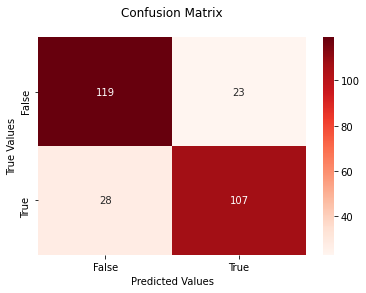

In [14]:
# As seen above
ax = sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

# <br />Part 2 - Improved Solution

Below is a list and summary of all changes in relation to the code in part 1.

### Improvement 1: N-Grams word search

Added a new parameter <code>ngram_range=(1, 5)</code> to the Vectorizer.<br />
This allows the vectorizer to search for the most significant set of words that occur together. The maximum n-gram range had been set to 5<br />Removed the <code>binary=True</code> parameter.<br />Increased the number of features extracted from the text from 750 to 3500, due to an increased number of possible valuable features.

<pre><code>vectorizer = CountVectorizer(max_features=3500,
                             vocabulary=self.vocabulary,
                             ngram_range=(1, 5),
                             preprocessor=preprocess)</code></pre>

### Improvement 2: Multinomial Naive Bayes

The equation for Multinomial Naive Bayes is as follows:<br />$$\hat{c} = argmax_{c∈\{0, 1\}}\biggl[log(p(C=c))+\sum \limits_{i=1}^{n}w_{i}\cdot log(\frac{N_{ci} +\alpha}{N_{c}+n\alpha})\biggr]$$<br />$$N_{ci}=\sum\limits_{w∈T}w_{i}$$<br />$$N_{c}=\sum\limits_{i=1}^{n}N_{ci}$$<br />where $N_{ci}$ represents the number of times the feature $i$ appears in a sample of class $c$ in the training set $T$, $N_{c}$ represents the total count of all features for class $c$, and $\alpha$ is a hyperparameter called Lidstone smoothing (ScikitLearn, 2022).<br />

Multinomial Naive Bayes is the best Naive Bayes algorithm for Text Classification and one of the best supervised learning methods for Natural Language Processing. This is because the text data itself is multinomially distributed.<br />
Multinomial Naive Bayes is a well-tried and tested method and is a natural improvement over the algorithm used in Part 1 of this assignment in which a a Bernoulli Naive Bayes was used. That is, the previous algorithm did not consider the frequency of the word used and only noted the appearance of that word. Nowadays, Bernoulli models are rarely used and most of the times it is agreed that Multinomial models outperform them. (Abbas et al., 2019)<br />
Another option could be to use Complement Naive Bayes algorithm, however it is be best suited for very imbalanced datasets, which is not the case in this scenario.

Steps to implement: Removing the custom <code>naiveBayes</code> and <code>evaluate</code> functions in place of simpler <code>sklearn.naive_bayes.MultinomialNB</code> call.<br />
Changing the save options to save the whole <code>MultinomialNB</code> model instead of saving weights

<pre>In <code>train()</code>:<code>
    model = MultinomialNB()
    model.fit(self.bag_of_words, self.training_labels)
    self.model = model

    if save_weights:
        np.savez_compressed('resources/weights_and_vocab_p2.npz', model=self.model,
                            vocab=self.vocabulary)
</code></pre>

<pre>In <code>__init__()</code>:<code>
    if saved_weights:
        """Loading saved model and vocabulary for predictions"""
        npz_files = np.load(saved_weights, allow_pickle=True)
        self.vocabulary = npz_files['vocab'].tolist()
        self.model = npz_files['model'].tolist()
    else:
        self.vocabulary = None
        self.model = None
</code></pre>

<pre>In <code>predict()</code>:<code>
    predictions = self.model.predict(features)
</code></pre>

### Improvement 3: TfIdfVectorizer

A great additive to the Multinomial Naive Bayes solution that is commonly used is TfIdfVectorizer.<br />
In comparison to the classic CountVectorizer, TfIdf offers extra statistical information about the extracted words.<br />
In the same journal that was quoted above (Abbas et al., 2019), the authors mention this vectorizer and lists it as a possible enhancement of their work.<br />
TfIdf stands for Term Frequency, Inverse Document Frequency. Term Frequency is a simple count of the number of times the word exists in the document - something that CountVectorizer is doing.<br />
What CountVectorizer isn't doing is Inverse Document Frequency. TfIdf, on top of regular word counting, calculates the number of documents containing a certain word, which is a divisor to a total number of documents in a dataset. This value is then log'ed and then multiplied by the Term Frequency.<br />
It all results in the following equation:
$$w_{i,j}=tf_{i,j}\cdot \biggl[log(\frac{N}{df_{i}})\biggl]$$
(Saket, 2020)


From the coding perspective, it simpy means that we are swapping out <code>CountVectorizer</code> for <code>TfidfVectorizer</code> from the same <code>sklearn.feature_extraction.text</code> library

<pre><code>vectorizer = TfidfVectorizer(max_features=3500,
                             vocabulary=self.vocabulary,
                             ngram_range=(1, 5),
                             preprocessor=preprocess)</code></pre>

### Improvement 4: Hyperparameters Cross-Validated Grid Search

Another great tool from sklearn library, that may serve to raise the accuracy of the model is <code>GridSearchCV</code>.<br />
Grid search, because the search takes place in the hyperparameter gridspace. In this case, for Multinomial Naive Bayes, the only hyperparameter that can be optimized is $\alpha$, which stands for Laplace/Lidstone smoothing.<br />
The first step is to define the search grid for $\alpha$. Then we can create the <code>GridSearchCV</code> object and fill out all the parameters. This object will fit the model repeatedly and will save the best performing model into a <code>best_estimator_</code> attribute, which we can write directly to <code>self.model</code> variable.

<pre><code>
grid = {'alpha': np.linspace(0.01, 1.01, num=101)}
findBestModel = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=grid,
    scoring='accuracy',
    cv=50)
findBestModel.fit(self.bag_of_words, self.training_labels)
self.model = findBestModel.best_estimator_
print(findBestModel.best_params_)
</code></pre>

According to the search above, the optimal value for $\alpha$ is 0.03. This is the value that I will use from now on.

### Improvement 5: Optimised Data Split

One thing that anyone trying to develop a model will notice is that the results are very dependant on the data split.<br />
Some splits are just better and some split are worse. However, they can have a great effect on the model's accuracy, therefore we want to have the best split possible.<br />
In order to do that, we could use tools like sklearn's <code>StratifiedShuffleSplit</code>, but for this search, we can simply write a for loop and iterate through the different splits and see which <code>random_state</code> is best.<br />I chose to iterate through 60 different states, as it seemed like an exhaustive enough sample that would not run for too long.

<pre><code>
states = []
accuracies = []
for i in range(1, 60):
    train_data, test_data = train_test_split(parsedData, test_size=0.2, random_state=i)

    classifier = SentimentClassifier()
    classifier.train(train_data, save_weights=False)
    _, accuracy = classifier.predict(test_data)
    states.append(i)
    accuracies.append(accuracy)

ax = sns.scatterplot(states, accuracies)
ax.set_xlabel('Random State')
ax.set_ylabel('Accuracy (%)')
plt.show()
</code></pre>

After letting this run for a few minutes, the script returns the following plot.

<figure>
<img src="resources/BestStateSearch.png", width=900>
    <figcaption></figcaption>
</figure>

At first glance, the variance between different splits is noticably high. Considering the fact that we're fighting over every little percent, this is a potentially great optimization boost.<br />
The values vary from the lowest scoring seed 20 getting only 73% to the highest scoring seed 28 getting nearly 86%. In general, most of the scores are contained in between 79% and 82%.<br />
From now on, we will carry on using the seed 28.

### Improvement 6: Optimised Vocabulary

Another thing which becomes apparent is that not all features that are being extracted from the vectorizer matter. There are features that exist in both classes at similar rates and filtering them away can reduce the vocabulary size and potentially improve the accuracy by a small margin.<br />
To do that, a function has been implemented that runs after the model has been trained. It iterates through every feature, calculates a standard deviation and if the result is less than a given threshold, it removes the feature from the model.

<pre><code>
def vocab_optimization(self):
    featuresToDelete = []

    def getWordFromVocab(i):
        for word, val in self.vocabulary.items():
            if val == i: return word

    for i, feature in enumerate(np.transpose(self.model.feature_log_prob_)):
        if np.std(feature) < self.threshold:
            del self.vocabulary[getWordFromVocab(i)]
            featuresToDelete.append(i)

    self.bag_of_words = np.delete(self.bag_of_words, featuresToDelete, axis=1)
    self.model.feature_count_ = np.delete(self.model.feature_count_, featuresToDelete, axis=1)
    self.model.feature_log_prob_ = np.delete(self.model.feature_log_prob_, featuresToDelete, axis=1)
    self.vocabulary = {word: i for i, word in enumerate(self.vocabulary)}
    self.model.n_features_in_ = len(self.vocabulary)
</code></pre>

The question arises, how to elect such parameter that would be the most beneficial to the model.<br />
This time, again, I've decided to modify the Classifier in a way that would allow me to pass the threshold in as an attribute and iterate through the parameter grid in search of the most successful one.<br />
I chose to design the gridspace in such a way that the plot would allow us to see the bigger picture and present how great of an effect threshold can play, thus the gridspace expanding all the way from 0 to 1.

<pre><code>
acc = []
vocab_size = []
for threshold in np.concatenate([np.linspace(1, 0.55, 10), np.linspace(0.5, 0.325, 8), np.linspace(0.30, 0, 49)]):
    classifier = SentimentClassifier(threshold=threshold)
    classifier.train(train_data, save_weights=False)
    _, accuracy = classifier.predict(test_data)
    acc.append(accuracy)
    vocab_size.append(classifier.model.n_features_in_)

ax = sns.scatterplot(vocab_size, acc)
ax.set_xlabel('Vocabulary Size')
ax.set_ylabel('Accuracy (%)')
plt.show()
</code></pre>

After letting this script run for approximately 15 minutes, here was the result.

<figure>
<img src="resources/LeastVocabSearch.png", width=900>
    <figcaption></figcaption>
</figure>

Looking at the plot above, we can notice that the number of features we have started with is far from optimal. We could get rid of at least 500 features without decreasing the accuracy (that would correspond to the threshold of 0.05625)<br />
However, in between 2500 and 2700 features, we notice a slight improvement in accuracy of approximately 0.4%, which corresponds to the thresholds between 0.09375 and 0.1125. This means that setting our threshold to ~0.1 actually improves model's performance a little bit.<br />
In the final version of this code, the value 0.1 is the one that will be used.

### Improvement 7: Ensemble Machine Learning

In this section, we'll try to elevate the algorithm one level further and introduce our Multinomial Naive Bayes model to a simple ensemble classifier.<br />
Ensemble machine learning methods allow for a creation of a bigger model consisting of multiple conventional models/estimators in such a way that, when put together, they perform better than they normally would on their own.<br />
The simplest ensemble method that best illustrates the idea behind it is a Voting Classifier. In it's basic form, it puts the estimators in a democratic environment where they 'vote' for what the output class should be.<br />
Another simple ensemble method is a Stacking Classifier. It consists of two layers of estimators. First layer contains a stack of estimators that are being trained in a regular way and they feed their outputs to the second layer. It consists of a single estimator that processes the outputs from the stack and returns the corrected outputs. A common choice for the final estimator is a Logistic Regression classifier, which is already a default option for this method in sklearn library. This is the algorithm that will be used in the final solution.<br /><br />
Ensemble methods are numerous and much more refined than the examples above. They are almost always outperforming single algorithms in practice and understanding them is a very important step to becoming a Machine Learning Engineer. The current solution is one of the easiest implementation of ensemble machine learning and this area holds a great potential for future improvement of this model.

The ensemble model for this solution will be a Stacking Classifier with a single estimator in a stack, which would be our already developed Multinomial Naive Bayes model, and a Logistic Regression algorithm as a final classifier.<br />
Logistic Regression hyperparameters have been established via a set of <code>GridSearchCV</code> instances that scanned through a multiple setting variations as shown below. Due to the length of this operation, I will simply summarise the findings and go through the different parameters in short.

<pre><code>
grid1 = {
    'penalty': ['l2', 'none'],
    'C': np.logspace(-3, 3, 20),
    'solver': ['lbfgs', 'newton-cg'],
}
grid2 = {
    'penalty': ['elasticnet'],
    'C': np.logspace(-3, 3, 20),
    'solver': ['saga'],
    'l1_ratio': np.linspace(0.001, 1, 21)
}
grid3 = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 20),
    'solver': ['saga']
}
</code></pre>

The most important parameter that defines other parameters is a solver. It is also the reason why I had to create three different grids for this search. The reason being, solvers are not compatible with some penalty parameters. There are five solvers that are supported in the sklearn library and here is in short how Jeff Hale explains them on his blog.<br />
 - <code>newton-cg</code> - uses a Hessian Matrix
 - <code>lbfgs</code> - uses second derivative matrix updates with gradient evaluations
 - <code>liblinear</code> - uses a coordinate descent algorithm (incompatible with a multinomial models, therefore ignored)
 - <code>sag</code> - uses a stochastic gradient descent
 - <code>saga</code> - is an extension of <code>sag</code> (generally better that its predecessor, therefore <code>sag</code> ignored)<br />
(Hale J., 2019)

The parameter that is most dependent on the solver is a penalty. There are four possible choices for this parameter and they are as follows:<br />
 - <code>l1</code> - L1 regularization - Incompatible with <code>newton-cg</code> and <code>lbfgs</code>
 - <code>l2</code> - L2 regularization
 - <code>elasticnet</code> - A combination of L1 and L2 regularizations. Requires a <code>l1_ratio</code> parameter - Supported only by <code>saga</code>
 - <code>none</code> - No regularization
 
In short, the main difference between L1 penalty and L2 penalty is the fact that L1 penalizes the sum of absolute values of the weights, whereas L2 penalizes the sum of squares of weights (Pykes, 2021).<br />
ElasticNet is a mix of the two above methods. It comes with its own parameter <code>l1_ratio</code>, that takes a float between 0 and 1. When set to 0, penalty is equivalent to L2 and when set to 1, it's equivalent to L1.<br />
The results of these three methods are comparable and the differences are small, therefore it's good to perform a search for the most optimal parameters.

The last parameter, <code>C</code> stands for inverse regularization strength and it indicates how strongly or weakly our regularization function will react to the distance of the fitted line from the data.

The results of the following Logistic Regression grid search were used in the Stacking Classifier model. The Accuracy shown is the final result of the whole ensemble model. 

The best performing parameters from the corresponding grids were:<br /><code>{'penalty': 'l2', 'C': 4.28133, 'solver': 'lbfgs'}</code> - Accuracy ~86.6%<br />
<code>{'C': 1.0, 'solver': 'saga', 'l1_ratio': 1.0}</code> - Accuracy ~87.7%<br />
<code>{'penalty': 'l1', 'C': 1.0, 'solver': 'saga'}</code> - Accuracy ~87.7%<br />

Looking at the test results, we can note that the bottom two are equivalent and they performed around a 1% better than the first model. The results of the third search will be used in the final version of the code.

In order to implement the ensemble method that was described above, the following modifications must be made:
Create another attribute called <code>self.ensemble</code> and use it as a saved and loaded model.
<pre><code>
if save_weights:
    np.savez_compressed('resources/weights_and_vocab_p2.npz', model=self.ensemble,
                        vocab=self.vocabulary)
</code></pre>
<pre><code>
if saved_weights:
    """Loading saved model and vocabulary for predictions"""
    npz_files = np.load(saved_weights, allow_pickle=True)
    self.vocabulary = npz_files['vocab'].tolist()
    self.ensemble = npz_files['model'].tolist()
</code></pre>
Then, create the ensemble classifier.
<pre><code>
"""Creating a Logistic Regression model with hyperparameters based of the GridSearch conducted previously"""
logistic_regression_model = LogisticRegression(penalty='l1', solver='saga', C=1.0)

"""Creating an fitting an ensemble model with LogisticRegression as a meta-estimator"""
self.ensemble = StackingClassifier(estimators=[('mnb', self.nb_model)],
                                   final_estimator=logistic_regression_model,
                                   passthrough=True,
                                   n_jobs=10).fit(self.bag_of_words, self.training_labels)
</code></pre>
Note that the attribute <code>self.model</code> containing our Multinomial Naive Bayes model has been renamed to <code>self.nb_model</code>

## Code for Part 2

In [15]:
import re
import time
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

In [16]:
class SentimentClassifierP2:
    def __init__(self, saved_weights=False):
        try:
            nltk.data.find('tokenizers/punkt')
            nltk.data.find('corpora/stopwords')
        except LookupError:
            nltk.download('punkt')
            nltk.download('stopwords')

        if saved_weights:
            """Loading saved model and vocabulary for predictions"""
            npz_files = np.load(saved_weights, allow_pickle=True)
            self.vocabulary = npz_files['vocab'].tolist()
            self.ensemble = npz_files['model'].tolist()
        else:
            self.vocabulary = None
            self.ensemble = None

        self.training_data = None
        self.training_labels = None
        self.bag_of_words = None
        self.nb_model = None
        self.vocab_std_threshold = 0.1

    @staticmethod
    def preProcessing(parsedData):
        """
        Given a dataset containing labels followed by the review comment,
        process the data into the right format - label turns into a boolean variable
        and a comment is being filtered out of the stop words,
        stemmed and parsed into a list of strings.

        :param parsedData: a two-dimensional array of input data
        :return: labels and processed data
        """
        stopWords = set(stopwords.words('english'))

        def filterStopWords(toFilter): return [word.lower() for word in toFilter if not word.lower() in stopWords]

        stemmer = SnowballStemmer(language='english')
        car_reviews = np.array(parsedData)

        for row in car_reviews:
            row[0] = 1 if row[0] == 'Pos' else 0
            row[1] = ' '.join([stemmer.stem(word) for word in filterStopWords(word_tokenize(row[1]))])

        return car_reviews[:, 0].astype(int), car_reviews[:, 1]

    def vectorize(self, data):
        """
        Vectorizing the text samples, saving the vocabulary and sorting it.

        :return bag_of_words: fully-processed text data
        """

        def preprocess(text):
            """Filtering out all the numbers and punctuation"""
            return re.sub(r'\d+|[.,-?!]', '', text)

        vectorizer = TfidfVectorizer(max_features=3500, vocabulary=self.vocabulary,
                                     ngram_range=(1, 5), preprocessor=preprocess)

        bag_of_words = vectorizer.fit_transform(data).toarray()
        if self.vocabulary is None:
            self.vocabulary = dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1]))

        return bag_of_words

    def vocab_optimization(self):
        """
        Optimizing the vocabulary by removing the words that seem
        to appear in both negative and positive reviews at similar rates.
        """
        featuresToDelete = []

        def getWordFromVocab(i):
            for word, val in self.vocabulary.items():
                if val == i: return word

        for i, feature in enumerate(np.transpose(self.nb_model.feature_log_prob_)):
            if np.std(feature) < self.vocab_std_threshold:
                del self.vocabulary[getWordFromVocab(i)]
                featuresToDelete.append(i)

        self.bag_of_words = np.delete(self.bag_of_words, featuresToDelete, axis=1)
        self.nb_model.feature_count_ = \
            np.delete(self.nb_model.feature_count_, featuresToDelete, axis=1)
        self.nb_model.feature_log_prob_ = \
            np.delete(self.nb_model.feature_log_prob_, featuresToDelete, axis=1)
        self.vocabulary = {word: i for i, word in enumerate(self.vocabulary)}
        self.nb_model.n_features_in_ = len(self.vocabulary)

    def train(self, data, save_weights=False):
        """
        Managing the data preprocessing.
        Creating and training the model.

        :param data: a two-dimensional array of input data
        :param save_weights: flag indicator to save the current weights and vocabulary for future predictions
        """
        self.training_labels, self.training_data = self.preProcessing(data)
        self.bag_of_words = self.vectorize(self.training_data)

        """Creating and fitting the Naive Bayes model with alpha based on the GridSearch conducted previously"""
        self.nb_model = MultinomialNB(alpha=0.03).fit(self.bag_of_words, self.training_labels)

        """Calling the vocabulary optimization method"""
        self.vocab_optimization()

        """Creating a Logistic Regression model with hyperparameters based of the GridSearch conducted previously"""
        logistic_regression_model = LogisticRegression(penalty='l1', solver='saga', C=1.0)

        """Creating an fitting an ensemble model with LogisticRegression as a meta-estimator"""
        self.ensemble = StackingClassifier(estimators=[('mnb', self.nb_model)],
                                           final_estimator=logistic_regression_model,
                                           passthrough=True,
                                           n_jobs=10).fit(self.bag_of_words, self.training_labels)

        if save_weights:
            np.savez_compressed('resources/weights_and_vocab_p2.npz', model=self.ensemble,
                                vocab=self.vocabulary)

    def predict(self, data):
        """
        Processing the input data and returning a set of predictions given by the trained model.

        :param data: a two-dimensional array of input data
        :return predictions: a vector of binary predictions
        """
        labels, processed_data = self.preProcessing(data)
        features = self.vectorize(processed_data)
        predictions = self.ensemble.predict(features)

        conf_matrix = confusion_matrix(labels, predictions)
        training_set_accuracy = np.mean(np.equal(predictions, labels)) * 100

        return conf_matrix, training_set_accuracy

In [17]:
parsedData = pd.read_csv('resources/car-reviews.csv')
train_data_P2, test_data_P2 = train_test_split(parsedData, test_size=0.2, random_state=28)

In [21]:
# This cell trains the model, saves the weights and tests the algorithm
# The operations are timed
# Uncomment the lines below to run the training process

# classifierP2 = SentimentClassifierP2()

# train_start_time = time.process_time()
# classifierP2.train(train_data_P2, save_weights=True)
# train_end_time = time.process_time()

# test_start_time = time.process_time()
# conf_matrixP2, accuracyP2 = classifierP2.predict(test_data_P2)
# test_end_time = time.process_time()

# print(f"Accuracy: {accuracyP2:.4f}%\n"
#       f"Training time: {train_end_time - train_start_time:.4f}s\n"
#       f"Testing time: {test_end_time - test_start_time:.4f}s\n")

Accuracy: 87.7256%
Training time: 8.4844s
Testing time: 0.9531s



In [19]:
# This cell loads the weights and tests the algorithm
classifierP2 = SentimentClassifierP2(saved_weights='resources/weights_and_vocab_p2.npz')

conf_matrixP2, accuracyP2 = classifierP2.predict(test_data_P2)

print(f"Accuracy: {accuracyP2:.4f}%\n")

Accuracy: 87.7256%



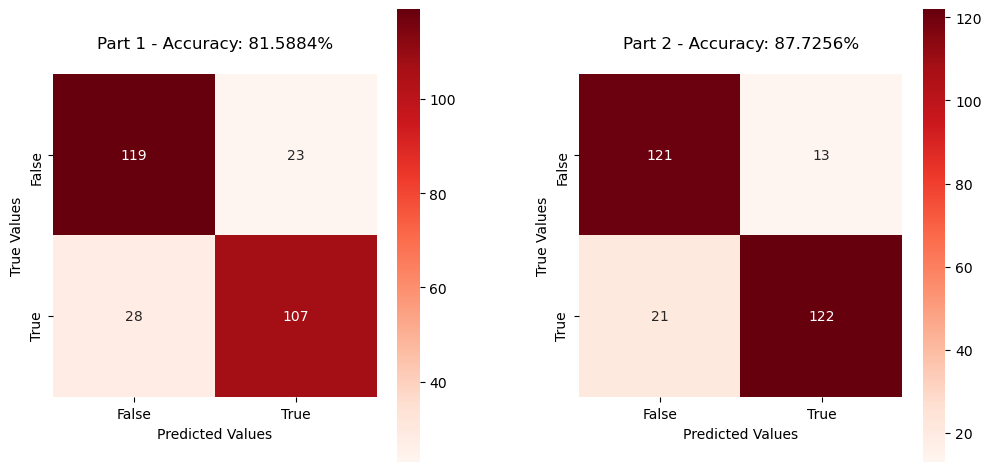

In [20]:
# Models from part 1 and part 2 side by side
train_data_P1, test_data_P1 = train_test_split(parsedData, test_size=0.2, random_state=42)

classifierP1 = SentimentClassifier(saved_weights='resources/weights_and_vocab.npz')

conf_matrixP1, accuracyP1 = classifierP1.predict(test_data_P1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
sns.heatmap(conf_matrixP1, annot=True, cmap='Reds', fmt='g', ax=ax1, square=True)
sns.heatmap(conf_matrixP2, annot=True, cmap='Reds', fmt='g', ax=ax2, square=True)
ax1.set_title(f"Part 1 - Accuracy: {accuracyP1:.4f}%\n")
ax2.set_title(f"Part 2 - Accuracy: {accuracyP2:.4f}%\n")
for ax in [ax1, ax2]:
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('True Values')
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])
plt.subplots_adjust(wspace=0.3)
plt.show()

# Conclusion
As we can see from the side-to-side comparison above, the model from part 2 have achieved an accuracy increase by an approximately ~6.1%.<br />
It took a number of parameter optimization, data processing improvement and model design development. In the end, the result is still a small, compact and a powerful model that uses simple measures in order to achieve high accuracy on a relatively small  dataset in sentiment classification.<br />
This degree of improvement may have been expected. The first model did not utilise the multinomiality of the features, which led to some data loss. N-Grams have enabled the model to be exposed to the larger sample and the ensemble combination with Logistic Regression improved the final result slightly, by validating the output against an algorithm with a different specification.<br />
The greatest and the easiest improvement comes from optimisation. Cross-validated grid search have been a major discovery throughout the course of this assignment and it has contributed greatly to maximising the score. No doubt that any future improvement will require a major redesign of the model and a greater commitment of the resources. I see a great potential in artificial neural networks (ANN). Definitely, a combination of ANNs and the current model is something that I would explore in the first place. I believe that given a larger dataset, this has a potential break the 90% accuracy barrier and looking at the literature for the subject, I don't see the reason why another iteration of the model wouldn't be able to reach 95% accuracy or higher. At this point, such robust algorithm could be ready for commercial use.

# References
Wikipedia, 2022. Naive Bayes classifier [Online]. Available from: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

ScikitLearn, 2022. Multinomial Naive Bayes [Online]. Available from: https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

Abbas, M., Memon, K.A., Jamali, A.A., Memon, S. and Ahmed, A. (2019). Multinomial Naive Bayes Classification Model for Sentiment Analysis. IJCSNS International Journal of Computer Science and Network Security, [online] 19(3), pp.62–67. Available at: https://www.researchgate.net/profile/Anees-Ahmed-5/publication/334451164_Multinomial_Naive_Bayes_Classification_Model_for_Sentiment_Analysis/links/5e227e8d92851cafc38c813c/Multinomial-Naive-Bayes-Classification-Model-for-Sentiment-Analysis.pdf

Saket, 2020. Count Vectorizer vs TFIDF Vectorizer | Natural Language Processing [Online]. Available from: https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/

Hale J., 2019. Don’t Sweat the Solver Stuff [Online]. Available from: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

Pykes K., 2021. Fighting Overfitting With L1 or L2 Regularization: Which One Is Better? [Online]. Available from: https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization